# SANTANDER DATA MASTER - CIENTISTA DE DADOS

### Questão b) Classificar clientes de 1 a 5

Descrição: A segunda tarefa consiste em dar uma nota de 1 a 5 para cada cliente da base teste, respeitando a variável ‘TARGET’, isto é, o seu nível de satisfação, sendo 1 o mais insatisfeito e 5 o mais satisfeito. Ao dar essa nota deve-se ter em mente que
somente os clientes com nota 1 serão alvos de uma ação de retenção e que o objetivo dessa ação é maximizar o lucro esperado por cliente (usando os mesmos valores da primeira questão).

In [ ]:
!pip install scikit-learn
!pip install imblearn
!pip install xgboost

In [29]:
#Imports

#Manipulação dos Dados
import pandas as pd
import numpy as np

#Visualização dos Dados
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import (make_scorer, confusion_matrix,
                             silhouette_score, roc_curve,
                             precision_recall_curve, classification_report)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb



In [11]:
df_train = pd.read_pickle('./train_1.pickle')
df_test = pd.read_pickle('./test_1.pickle')

In [12]:
df_train.shape,df_test.shape

((76020, 142), (75818, 141))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['TARGET','ID'], axis = 1), df_train.TARGET, stratify = df_train.TARGET, train_size = 0.80 ,random_state = 42)

In [14]:
smote = SMOTE(sampling_strategy='minority')
X_over, y_over = smote.fit_resample(X_train,y_train)

In [15]:
X_over.shape, y_over.shape

((116820, 140), (116820,))

In [16]:
(y_over.value_counts()/y_over.count())*100

1    50.0
0    50.0
Name: TARGET, dtype: float64

In [19]:
params_rf = {'class_weight':'balanced',
             'max_leaf_nodes':250,
             'max_depth': 1000,
             'min_samples_leaf': 3,
             'min_samples_split': 100,
             'n_estimators': 2000,
             'random_state': 12345}

rf_optimized = RandomForestClassifier(**params_rf)
rf_optimized.fit(X_over, y_over)

RandomForestClassifier(class_weight='balanced', max_depth=1000,
                       max_leaf_nodes=250, min_samples_leaf=3,
                       min_samples_split=100, n_estimators=2000,
                       random_state=12345)

In [20]:
y_predicted = rf_optimized.predict_proba(X_test)[:,1]
auc(y_test, y_predicted)

0.8115657710385098

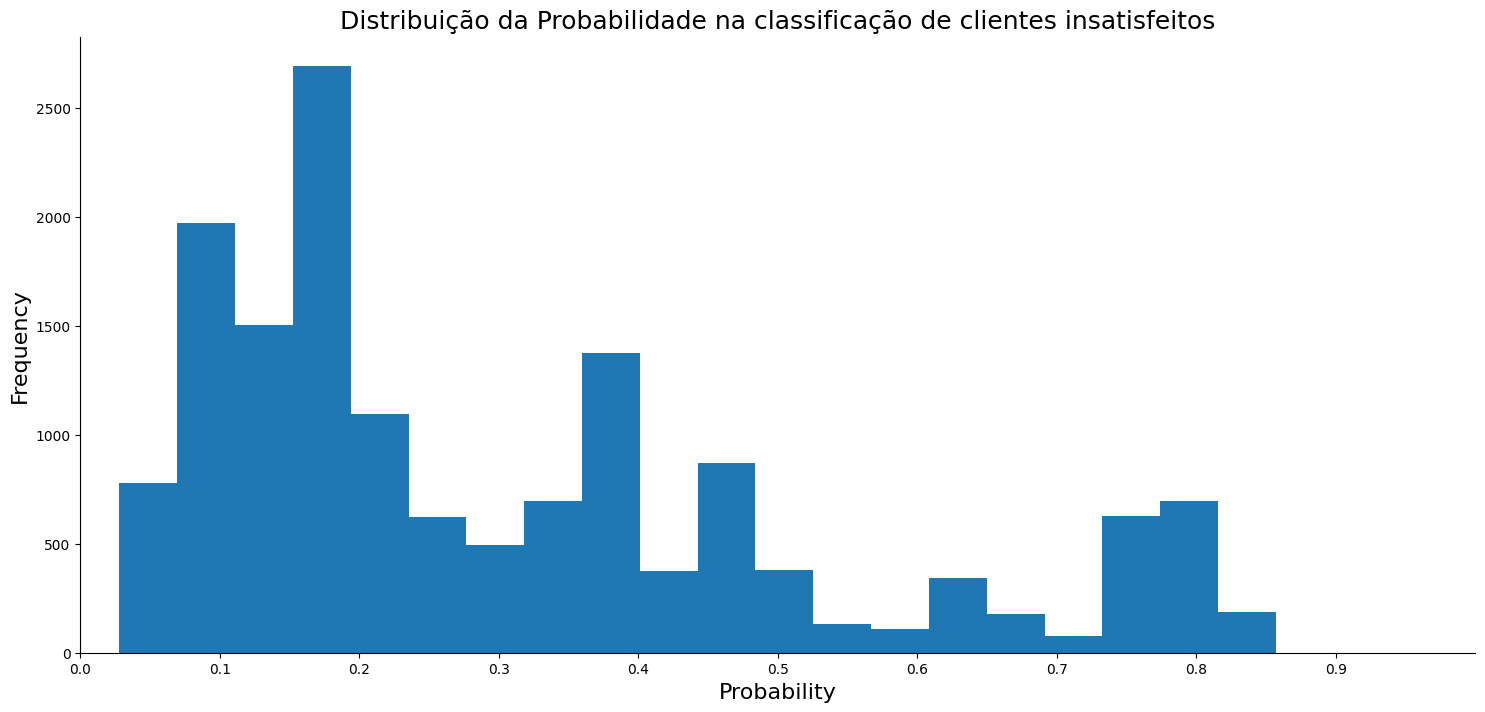

In [24]:
fig, ax = plt.subplots(figsize = (18, 8))
ax.hist(rf_optimized.predict_proba(X_test)[:,1], bins = 20);
ax.set_xlim(0, 1);
plt.xticks(np.arange(0, 1, 0.1))
plt.title('Distribuição da Probabilidade na classificação de clientes insatisfeitos', fontsize=18);
plt.ylabel('Frequency', fontsize=16);
plt.xlabel('Probability', fontsize=16);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Conforme o gráfico acima, a probabilidades tem maior ocorrência até 0,5.

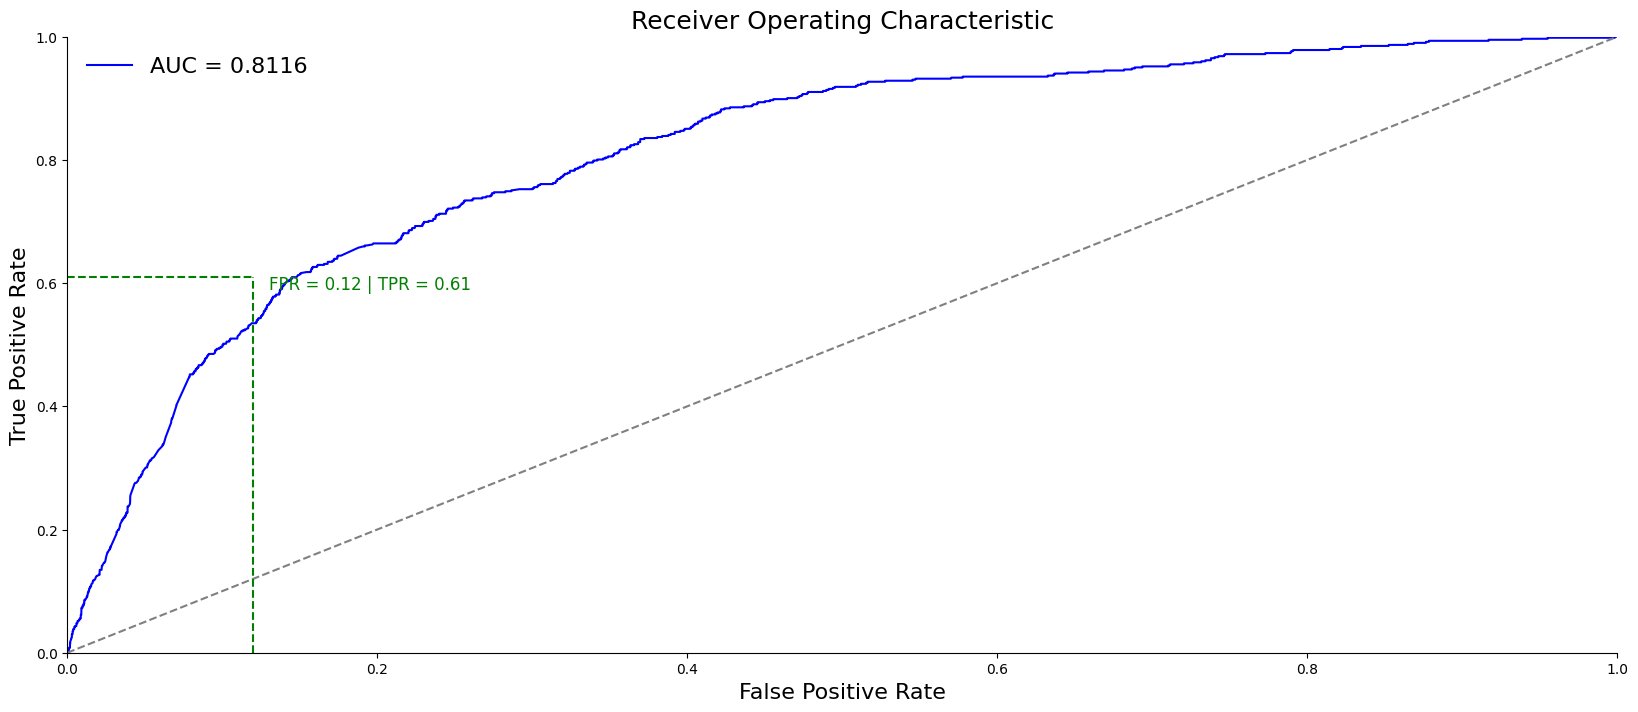

In [25]:
import sklearn.metrics as metrics

# Calculate FPR and TPR for all thresholds
fpr, tpr, threshold = metrics.roc_curve(y_test, y_predicted)
roc_auc = metrics.auc(fpr, tpr)

# Plotting the ROC curve
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (20, 8))
plt.title('Receiver Operating Characteristic', fontsize=18)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc = 'upper left', fontsize = 16, frameon = False)
plt.plot([0, 1], [0, 1], color = 'grey', linestyle = '--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 16)
plt.xlabel('False Positive Rate', fontsize = 16)

ax.plot([0.12, 0.12], [0, 0.61], color='green', linestyle='dashed', label='FPR = 0.12')
ax.plot([0, 0.12], [0.61, 0.61], color='green', linestyle='dashed', label='FPR = 0.12')
plt.text(0.13, 0.59, 'FPR = 0.12 | TPR = 0.61', fontsize = 12, color = 'green')

plt.show()

In [27]:
y_pred_train = rf_optimized.predict(X_over)

In [28]:
y_pred_proba_train = rf_optimized.predict_proba(X_over)[:,1]
y_pred = rf_optimized.predict(X_test)
y_pred_proba = rf_optimized.predict_proba(X_test)[:,1]

In [31]:
pr, recall, thr = precision_recall_curve(y_test, y_pred_proba)
pr_train, recall_train, thr_train = precision_recall_curve(y_over, y_pred_proba_train)

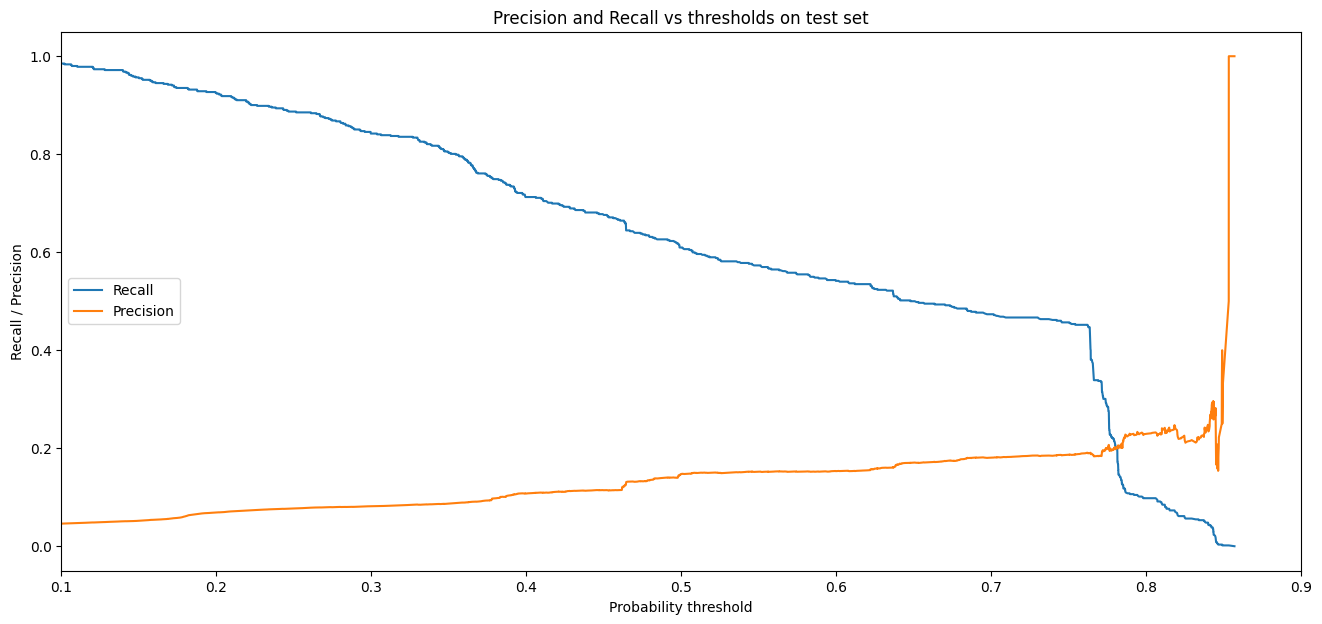

In [32]:
_ = plt.figure(figsize=(16,7))
_ = plt.plot(thr, recall[1:],label='Recall')
_ = plt.plot(thr, pr[1:],label='Precision')
_ = plt.xlabel('Probability threshold')
_ = plt.ylabel('Recall / Precision')
_ = plt.title('Precision and Recall vs thresholds on test set')
_ = plt.legend()
_ = plt.xlim([0.1,0.9])
plt.show()

In [45]:
def max_profit_score(y_true, y_pred):
    """
    Função que avalia o modelo computando o lucro esperado
    da ação de retenção dos clientes insatisfeitos.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    FP = conf_matrix[0][1] # Falsos positivos
    TP = conf_matrix[1][1] # Verdadeiros positivos
    
    lucro = 90*TP - 10*FP # lucro da acao de retencao (os 
                          # verdadeiros e falsos negativos
                          # não contribuem em
                          # nada no lucro)
    print(FP, TP)
    return lucro

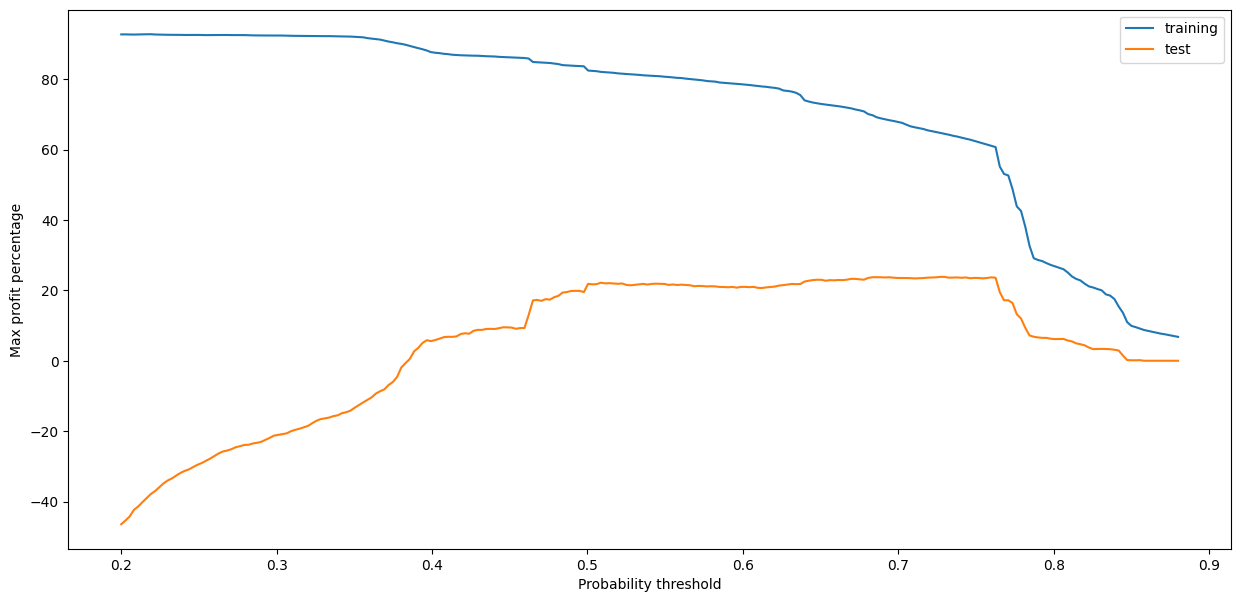

In [38]:
thresholds = np.linspace(0.2,0.88,250)
total_profit_percentage = [max_profit_score(y_over, (y_pred_proba_train > i)*1)/(y_over.sum()*90)*100 for i in thresholds]
total_profit_percentage_test = [max_profit_score(y_test, (y_pred_proba > i)*1)/(y_test.sum()*90)*100 for i in thresholds]
_ = plt.figure(figsize=(15,7))
_ = plt.plot(thresholds, total_profit_percentage, label='training')
_ = plt.plot(thresholds, total_profit_percentage_test, label='test')
_ = plt.ylabel('Max profit percentage')
_ = plt.xlabel('Probability threshold')
_ = plt.legend()

In [39]:

threshold_for_max_profit = thresholds[np.argmax(total_profit_percentage)]
print(threshold_for_max_profit)


0.21911646586345382


In [40]:
print(classification_report(y_test, (y_pred_proba > threshold_for_max_profit)*1) )

              precision    recall  f1-score   support

           0       0.99      0.52      0.68     14602
           1       0.07      0.91      0.13       602

    accuracy                           0.54     15204
   macro avg       0.53      0.72      0.41     15204
weighted avg       0.96      0.54      0.66     15204



In [41]:
notas = pd.cut(y_pred_proba, bins=list(np.linspace(0,threshold_for_max_profit,5))+[1.0], labels=[5,4,3,2,1])

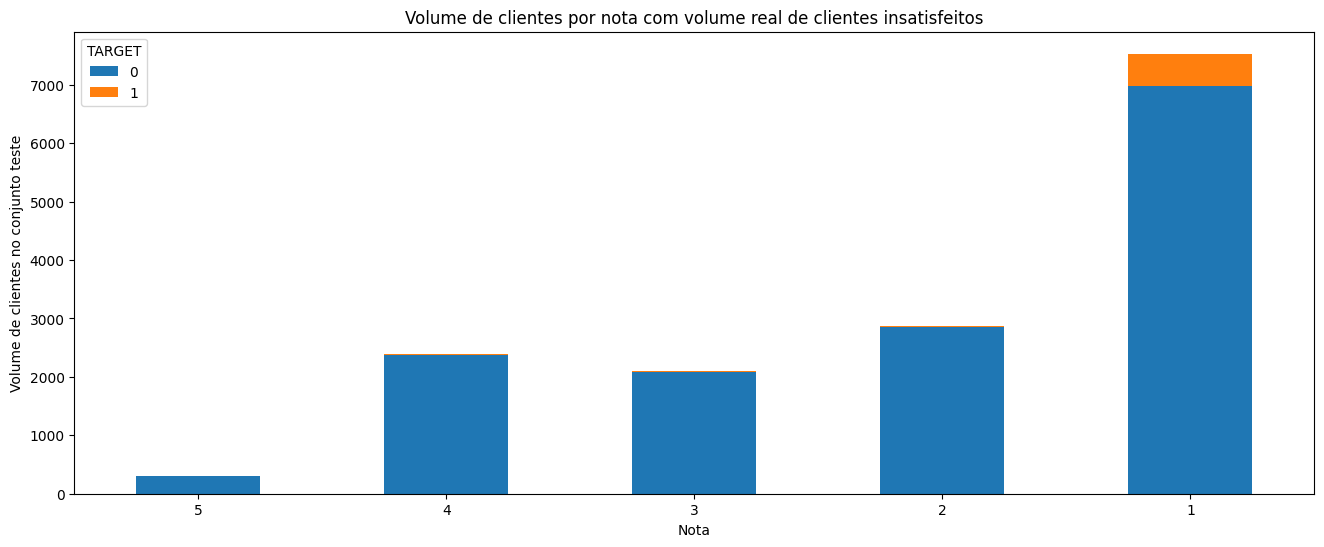

In [43]:
_ = pd.concat((pd.Series(notas, name='notas'), y_test.reset_index(drop=True)), axis=1, ignore_index=False).\
    groupby(['TARGET','notas']).size().unstack('TARGET').plot.bar(stacked=True,figsize = (16,6))
_ = plt.xticks(rotation=0)
_ = plt.ylabel('Volume de clientes no conjunto teste')
_ = plt.xlabel('Nota')
_ = plt.title('Volume de clientes por nota com volume real de clientes insatisfeitos')

In [46]:
print("Lucro total das notas 1 no conjunto de treinamento: R$ "+str(max_profit_score(y_test, (notas == 1)*1)))
print("Representando "+str(round(max_profit_score(y_test, (notas == 1)*1)/(y_test.sum()*90)*100,1))+ "% do máximo lucro possível no conjunto de teste.")


6982 548
Lucro total das notas 1 no conjunto de treinamento: R$ -20500
6982 548
Representando -37.8% do máximo lucro possível no conjunto de teste.
